# Pre-Preocess Global Rainfall Data 

The notebook pre-processes global rainfall data for specific Areas of Interest (AOIs). This global rainfall data is provided as monthly sum GeoTiff files. For a given UTM zone, the monthly rainfall sum files are first cropped to the latitude band of the desired AOI. Then, a yearly sum is computed as an intermediate output. This yearly sum is used to calculate a single daily average GeoTiff file for the specified UTM zone and latitude band that covers the country of interest. The file structure is indicated below. 

The source data is available globally [here](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/tifs/) for 2023 as monthly rainfall totals in mm. Also availble [here](https://dataexchange.gatesfoundation.org/dataset/chirps_rainfall_dataset_2022/resource/c9a40f6d-09d3-4b00-894b-8864573b82f8) for 2022.

## File System Structure
The top level file structure is shown below which includes five folders and three notebooks. This notebook is used to process global rainfall data as described below.

<pre style="font-family: monospace;">
<span style="color: gray;">./AOI</span>
<span style="color: gray;">./DHS</span>
<span style="color: gray;">./Nightlights</span>
<span style="color: gray;">./Population</span>
<span style="color: blue;">./Rainfall</span>

<span style="color: gray;">./prep_aoi_image_tiles.ipynb</span>
<span style="color: gray;">./prep_geospatial_data.ipynb</span>
<span style="color: blue;">./prep_rainfall_chirps.ipynb (this notebook)</span>
</pre>

## **Input (Global Monthly Rainfall):**

The following file structure is required as input for this notebook. The Chirps dataset consists of 12 monthly global rainfall GeoTiff files as indicated below.

<pre style="font-family: monospace;">
./Rainfall/
    Chirps_2023/
        chirps-v2.0.2023.01.tif
        :
        :
        chirps-v2.0.2023.12.tif
</pre>

## **Output (AOI Daily Average per UTM Zone):**

The following file structure will be created by this notebook. The 12 global monthly rainfall GeoTiff files are processed to produce daily average rainfall GeoTiff files for the specified country and UTM zone which also requires the specification of a latitude band for the AOI.


<pre style="font-family: monospace;">
./Rainfall/
    Chirps_2023/
        PK/
            /42N
                AOI_crop_daily_average/
                    chirps-v2.0.2023_PK_42N_avg.tif
</pre>

## Required Configurations

The following configurations are required for each execution of this notebook: the two-letter country code, and the UTM Zone. The UTM zone combined with the country latitude band define the cropped region to be processed to compute the daily average rainfall. This notebook must be executed once for each UTM zone.

<pre style="font-family: monospace;">
<span style="color: blue;">country_code= 'PK'</span>  # Set the country code
<span style="color: blue;">utm_zone    = '42N'</span> # Set the UTM zone
</pre>

# UTM Zones by Country
The following table is provided as a convenient reference for countries of interest and their corresponding UTM zones.
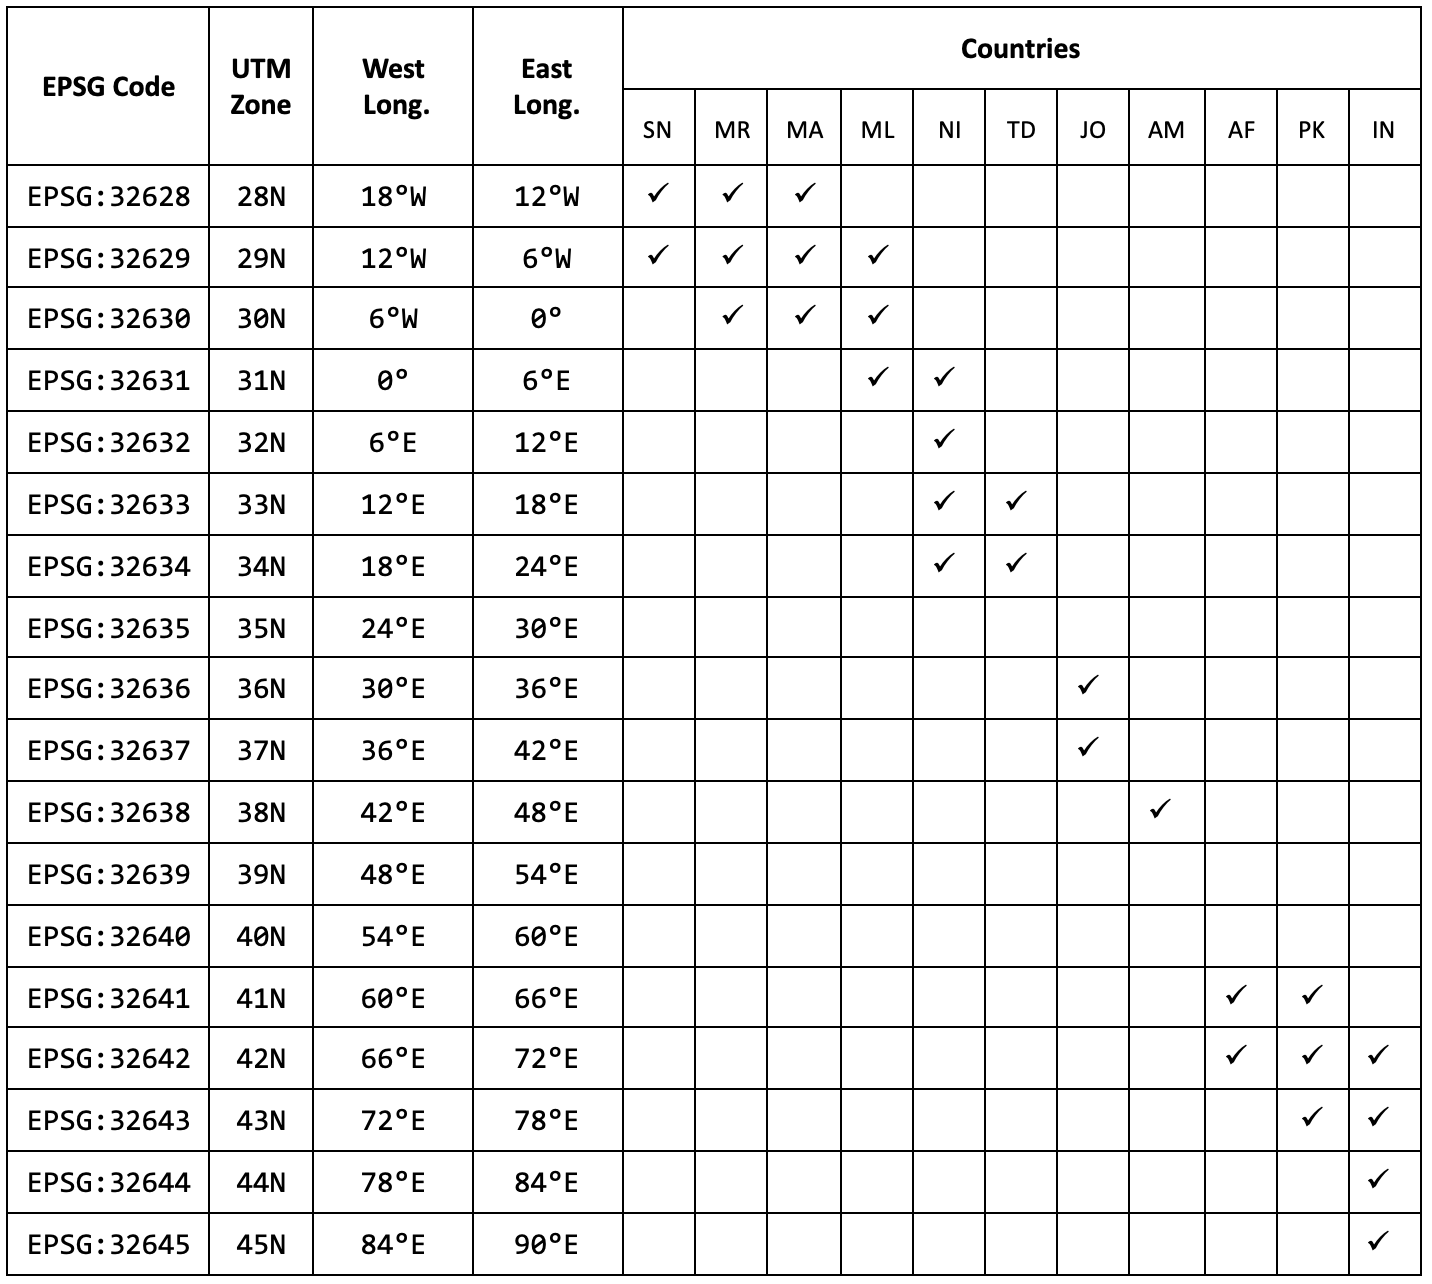


In [1]:
import os
from dataclasses import dataclass

# Import module that contains several convenience functions (e.g., gdal wrappers)
from gist_utils import *

# Adding path to gdal commands for local system
os.environ['PATH'] += ':/Users/billk/miniforge3/envs/py39-pt/bin/' 

## 1 Set Country Code and UTM Zone

The only input settings required in this notebook are the two-letter country code, UTM zone, and the latitude band for the specified UTM zone.

In [14]:
# Note: The latitude bands for each country below encompass the DHS survey locations which are often 
# narrower than the latitude bounds of the entire country.

aoi_configurations = {
    
   'AM': {
        'countrty': 'Armenia',
        'valid_zones': ['38N'],
        'lat_north': 42.0,
        'lat_south': 38.0,
    },
    
   'JO': {
        'countrty': 'Jordan',
        'valid_zones': ['29N', '30N'],
        'lat_north': 33.0,
        'lat_south': 29.0,
    },
    
    'MA': {
        'countrty': 'Mauritania',
        'valid_zones': ['28N', '29N', '30N'],
        'lat_north': 36.0,
        'lat_south': 26.0,
    },
    
    'ML': {
        'countrty': 'Mali',
        'valid_zones': ['29N', '30N', '31N'],
        'lat_north': 19.0,
        'lat_south': 10.0,
    },

    'MR': {
        'countrty': 'Morocco',
        'valid_zones': ['28N', '29N', '30N'],
        'lat_north': 26.0,
        'lat_south': 14.0,
    },
    
    'NI': {
        'countrty': 'Niger',
        'valid_zones': ['31N', '32N', '33N'],
        'lat_north': 19.0,
        'lat_south': 11.0,
    },
    
    'PK': {
        'countrty': 'Pakistan',
        'valid_zones': ['41N', '42N', '43N'],
        'lat_north': 37.0,
        'lat_south': 24.0,
    },
    
    'SN': {
        'countrty': 'Senegal',
        'valid_zones': ['28N', '29N'],
        'lat_north': 17.0,
        'lat_south': 12.0,
    },
    
    'TD': {
        'countrty': 'Chad',
        'valid_zones': ['33N', '34N'],
        'lat_north': 24.0,
        'lat_south': 7.0,
    }
}

# Function to check if a UTM zone is valid for a given country
def is_valid_zone(country_code, utm_zone):
    return utm_zone in configurations[country_code]['valid_zones']

In [15]:
#-------------------------------------------------
# REQUIRED CONFIGURATIONS HERE
#-------------------------------------------------
country_code = 'TD'   # Set the country code
utm_zone     = '34N'  # Set the desired UTM zone
#-------------------------------------------------

# Check if the selected UTM zone is valid for the chosen country
if is_valid_zone(country_code, utm_zone):
    lat_north = configurations[country_code]['lat_north']
    lat_south = configurations[country_code]['lat_south']
    print(f"Country:   {country_code}\nUTM Zone:  {utm_zone}\nLat North: {lat_north}\nLat South: {lat_south}\n")
else:
    print(f"UTM Zone {utm_zone} is not valid for country {country_code}.")
    
utm_code = get_epsg_code(utm_zone)
case = country_code + '_' + utm_zone 

print(utm_code)
print(case)

Country:   TD
UTM Zone:  34N
Lat North: 24.0
Lat South: 7.0

EPSG:32634
TD_34N


In [4]:
@dataclass(frozen=True)
class AOIConfig:
    UTM_CODE:    str                        # UTM code 
    LAT_NORTH:   float                      # Define max latitude for AOI
    LAT_SOUTH:   float                      # Define min latitude for AOI
    UTM_BUF_DEG: float = 1.0
        
@dataclass(frozen=True)
class DatasetConfig:
    COUNTRY_CODE:  str
    UTM_ZONE:      str
    DATA_DIR:      str = './Rainfall/Chirps_2023/'
    OUT_DIR_CROP:  str = './Rainfall/Chirps_2023/{country_code}/{utm_zone}/AOI_crop_monthly'  
    OUT_DIR:       str = './Rainfall/Chirps_2023/{country_code}/{utm_zone}/AOI_crop_daily' 
    OUT_BASE:      str = 'chirps-v2.0.2023'
    GDAL_INFO:    bool = False

    def get_out_dir_crop(self):
        return self.OUT_DIR_CROP.format(country_code=self.COUNTRY_CODE, utm_zone=self.UTM_ZONE)
    
    def get_out_dir(self):
        return self.OUT_DIR.format(country_code=self.COUNTRY_CODE, utm_zone=self.UTM_ZONE)

# Instantiate data classes
data_config = DatasetConfig(COUNTRY_CODE=country_code, UTM_ZONE=utm_zone)
aoi_config  = AOIConfig(UTM_CODE=utm_code, LAT_NORTH=lat_north, LAT_SOUTH=lat_south)

In [5]:
print(data_config.get_out_dir_crop())
print(data_config.get_out_dir())
print(aoi_config.UTM_CODE)

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly
./Rainfall/Chirps_2023/TD/34N/AOI_crop_daily
EPSG:32634


In [6]:
# Set output filenames
output_sum = data_config.get_out_dir() + "/" + data_config.OUT_BASE + "_" + case + "_sum.tif"
output_avg = data_config.get_out_dir() + "/" + data_config.OUT_BASE + "_" + case + "_avg.tif"

print("output_sum will be saved here: ", output_sum)
print("output_avg will be saved here: ", output_avg)

output_sum will be saved here:  ./Rainfall/Chirps_2023/TD/34N/AOI_crop_daily/chirps-v2.0.2023_TD_34N_sum.tif
output_avg will be saved here:  ./Rainfall/Chirps_2023/TD/34N/AOI_crop_daily/chirps-v2.0.2023_TD_34N_avg.tif


In [7]:
# Create output folders if they do not already exist
if not os.path.exists(data_config.get_out_dir_crop()):
    os.makedirs(data_config.get_out_dir_crop())
    
if not os.path.exists(data_config.get_out_dir()):
    os.makedirs(data_config.get_out_dir())

## 2 Define the Cropped Region
The cropped region is defined by the UTM zone specified above and the desired latitude bands that span the region of interest.

In [8]:
# Define the longitude booundaries for the specified UTM zone
utm_west_lon, utm_east_lon = utm_zone_longitude_bounds(aoi_config.UTM_CODE)

# Define AOI to encompass local UTM zone (+/- small buffer). Choose latitude to cover data for region
ul_lat, ul_lon = aoi_config.LAT_NORTH, utm_west_lon - aoi_config.UTM_BUF_DEG
lr_lat, lr_lon = aoi_config.LAT_SOUTH, utm_east_lon + aoi_config.UTM_BUF_DEG

# Print the results
print(f"Upper Left Lat: {ul_lat}")
print(f"Upper Left Lon: {ul_lon}")
print(f"Lower Right Lat: {lr_lat}")
print(f"Lower Right Lon: {lr_lon}")

epsg_code:  EPSG:32634
Upper Left Lat: 24.0
Upper Left Lon: 17.0
Lower Right Lat: 7.0
Lower Right Lon: 25.0


### Confirm Input Files

In [9]:
# Create a list of all files in the directory
files_in_directory = os.listdir(data_config.DATA_DIR)

# Filter the list to include only TIFF files
tiff_files = sorted([file for file in files_in_directory if file.endswith('.tif')])

for file in tiff_files:
    print(file)

chirps-v2.0.2023.01.tif
chirps-v2.0.2023.02.tif
chirps-v2.0.2023.03.tif
chirps-v2.0.2023.04.tif
chirps-v2.0.2023.05.tif
chirps-v2.0.2023.06.tif
chirps-v2.0.2023.07.tif
chirps-v2.0.2023.08.tif
chirps-v2.0.2023.09.tif
chirps-v2.0.2023.10.tif
chirps-v2.0.2023.11.tif
chirps-v2.0.2023.12.tif


## 3 Crop the Source Files 

In [10]:
# Loop through each TIFF file
for file_name in tiff_files:
    
    input_tif = os.path.join(data_config.DATA_DIR, file_name)
    
    # Construct the output file name based on the input file name
    temp = '_' + case + "_crop.tif"
    intermediate_tif = os.path.join(data_config.get_out_dir_crop(), os.path.splitext(file_name)[0] + temp)
    print(intermediate_tif)
    # Crop the data
    gdal_crop(input_tif, intermediate_tif, ul_lon, ul_lat, lr_lon, lr_lat, False)

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.01_TD_34N_crop.tif
Input file size is 7200, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.02_TD_34N_crop.tif
Input file size is 7200, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.03_TD_34N_crop.tif
Input file size is 7200, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.04_TD_34N_crop.tif
Input file size is 7200, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.05_TD_34N_crop.tif
Input file size is 7200, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.06_TD_34N_crop.tif
Input file size is 7200, 2000
0...10...20.

### Confirm the Cropped Files

In [11]:
# List all the cropped TIFF files
cropped_files = [os.path.join(data_config.get_out_dir_crop(), file) for file in os.listdir(data_config.get_out_dir_crop()) if file.endswith('.tif') or file.endswith('.tiff')]

for file in cropped_files:
    print(file)

./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.01_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.10_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.09_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.06_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.11_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.08_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.07_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.05_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.02_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.03_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.12_TD_34N_crop.tif
./Rainfall/Chirps_2023/TD/34N/AOI_crop_monthly/chirps-v2.0.2023.04_TD_34N_crop.tif


## 4 Compute the Yearly Sum

In [12]:
# Compute the yearly sum
sum_rasters(cropped_files, output_sum)

Sum of rasters successfully saved to: ./Rainfall/Chirps_2023/TD/34N/AOI_crop_daily/chirps-v2.0.2023_TD_34N_sum.tif
Output from command:
0...10...20...30...40...50...60...70...80...90...100 - done.



## 5 Compute the Daily Average

In [13]:
# Set the input file to the sum computed above
input_file = output_sum

# Compute the daily average
average_raster(input_file, output_avg, divisor=365)

Average operation successfully saved to: ./Rainfall/Chirps_2023/TD/34N/AOI_crop_daily/chirps-v2.0.2023_TD_34N_avg.tif
Output from command:
0...10...20...30...40...50...60...70...80...90...100 - done.

